## Setup

In [3]:
#!pip install pytorch_pretrained_bert

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 63.3 MB/s 
     |████████████████████████████████| 182 kB 61.1 MB/s 


In [5]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

from transformers import BertTokenizer, BertModel, BertForMaskedLM
from scipy.spatial.distance import cosine
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import matplotlib

In [6]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

## Plotting functions

In [7]:
def map_on_3d(data_2d, words, color_mapping:None, exceptional_words=[], use_word_colors=False, fig_size=[19,11], title=""):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    ax = plt.axes(projection ="3d")
    #scatter result words
    ax.scatter3D(data_2d[:, 0], data_2d[:, 1], data_2d[:, 2])
    plt.title(title)
    for i, word in enumerate(words):
        ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2], word, color=color_mapping[word_pos[i]])
    plt.show()

def get_color_mapping(Ys,color_by="verb"):
  mapped_colors = []
  if color_by == "verb":    
    colors =["#ff0000","#00dd00","#0000dd"] 
    verbs = ["adverb","eat","drink"," read"] #bread has "read" process carefully
    for y in Ys:
      indexes = [i for i,verb in enumerate(verbs) if y.find(verb) > -1]
      mapped_colors.append(colors[indexes[0]] )

  if color_by == "object":    
    colors =["#ff0000","#aaaa00","#00ff00","#000220","#0000ff","#00aaaa"] 
    #objects = ["apple","bread","water","beer","book","newspaper"]
    objects = ["above","down","all","genetic","book","newspaper"]
    for y in Ys:
      indexes = [i for i,object in enumerate(objects) if y.find(object) > -1]
      mapped_colors.append(colors[indexes[0]] )
  return mapped_colors  

def get_color_util(word_pos):
    """returns list of color codes for each item in word_POS"""
    unique_word_pos = list(set(word_pos))
    colors = ['#BCEE68', '#BF3EFF','#00BFFF', '#FF7D40', '#FFC125']
    d = {}
    import random
    for i in range(len(unique_word_pos)):
        #r = lambda: random.randint(0,255)
        #d[pos] = '#%02X%02X%02X' % (r(),r(),r())
        d[unique_word_pos[i]] = colors[i]
    return d

def map_on_2d(data_2d,words,color_mapping=None,exceptional_words=[],use_word_colors=False,fig_size=[16,11],title="",word_pos=None):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])
    plt.scatter(data_2d[:, 0], data_2d[:, 1])        
    plt.title(title)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]), color=color_mapping[word_pos[i]])
    plt.show()   


def dump_on_surface(Xs,Ys,fitting="tsne",dump_3d=True,dump_2d=True,color_by="verb",title="", word_pos=None):
    ## commented the below because it takes color mapping which is hardcoded
    ## not required as of now
    # color_mapping = get_color_mapping(Ys,color_by)
    
    colors_pos = get_color_util(word_pos)
    if dump_3d:    
        X_transformed = None
        if fitting=="tsne":
          X_transformed = PCA(n_components=3).fit_transform(np.array(Xs))
        else:   
          X_transformed = TSNE(n_components=3).fit_transform(np.array(Xs))
        map_on_3d(np.array(X_transformed), 
                  Ys, 
                  color_mapping=colors_pos, 
                  use_word_colors=False, 
                  fig_size=[10,10], 
                  title=title,
                  word_pos=word_pos)
    if dump_2d:    
        pca = PCA(n_components=2)
        X_transformed = pca.fit_transform(np.array(Xs))
        map_on_2d(np.array(X_transformed),
                  Ys,
                  color_mapping=colors_pos,
                  use_word_colors=False,
                  fig_size=[10,10],
                  title=title,
                  word_pos=word_pos)

## Helper functions

In [8]:
#Bert utility methods to use in this tutorial. these methods are not optimized
#because it processes 1-by-1 , in real usage these methods must process multi-sentences at once


#Bert model returns 3 things : last_hidden_state, pooler_output, hidden_states
#last_hidden_state : last output of network [batch x seq_len x 768]
#pooler_output : the ouput of last piece of network [batch  x 768]
#hidden_states : all outputs of all layers(13 layers) each [batch x seq_len x 768]
def get_bert_output(tokenizer_,model_,sentence):
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer_.tokenize(bert_text)
  indexed_tokens = tokenizer_.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  
  outputs = model_(tokens_tensor, segments_tensors)
  return outputs  

#pooler is layer after transformers , use this output for classification tasks
#  (pooler): BertPooler(
#    (dense): Linear(in_features=768, out_features=768, bias=True)
#    (activation): Tanh()
#  )
def get_bert_output_pooled(tokenizer_,model_,sentence):  
  outputs = get_bert_output(tokenizer_,model_,sentence)
  output_pooled =  outputs["pooler_output"] 
  return output_pooled.squeeze()  

#last hidden state of CLS token represents sentence embedding
def get_bert_output_cls(tokenizer_,model_,sentence):    
  outputs = get_bert_output(tokenizer_,model_,sentence) 
  cls_output = outputs["last_hidden_state"].squeeze()[0]
  return cls_output


#hidden layers are 1 initial embedding + 12 bert tranformer = 13 layers
def get_bert_hidden_layers(tokenizer_,model_,sentence):
  outputs = get_bert_output(tokenizer_,model_,sentence)
  hidden_states = outputs["hidden_states"]
  return hidden_states  

#try different architectures that best fits your problem ,
#I can give combination of different layers and try which combination of hidden states best fit to
#your target problem
def get_sentence_embedding(tokenizer_,model_,sentence,layer_start=-4,layer_end=None,type="sumsum"):
  hidden_states = get_bert_hidden_layers(tokenizer_,model_,sentence)
  effective_layers = torch.stack(hidden_states[layer_start:layer_end])
  
  if type == "sumsum":
    sentence_embedding = torch.sum(effective_layers.sum(0).squeeze(), dim=0) 
  elif type == "summean":  
    sentence_embedding = torch.sum(effective_layers.mean(0).squeeze(), dim=0) 
  elif type == "meanmean":  
    sentence_embedding = torch.mean(effective_layers.mean(0).squeeze(), dim=0)    
  else:
    sentence_embedding = torch.mean(effective_layers.sum(0).squeeze(), dim=0)      

  return sentence_embedding



#all hidden transformer states
def get_bert_transformer_layers(tokenizer_,model_,sentence):  
  hidden_states = get_bert_hidden_layers(tokenizer_,model_,sentence)

  token_embeddings = torch.tensor( [h.detach().numpy() for h in hidden_states[1:]])
  token_embeddings = token_embeddings.squeeze()
  token_embeddings = token_embeddings.permute(1,0,2)
  return token_embeddings

 


#best practise is concating last 4 layers
#Steps to create a word embedding
#1) get all transformer layer outputs(12x768 for 1 word)
#2) do a summarization of 12 vector(mean,sum,pool,concat ...)
def get_word_embeddings_sum(tokenizer_,model_,sentence) :
  token_embeddings = get_bert_transformer_layers(tokenizer_,model_,sentence)  
  word_embeddings = []
  for token in token_embeddings:
    #torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)        
    sum_vec = torch.sum(token[-4:], dim=0)   
    word_embeddings.append(sum_vec)

  return word_embeddings 

class EmbeddingPair:
  def __init__(self,word,vector):
    self.word = word
    self.vector = vector

#return token -> token_embedding as pairs.    
def get_embeddings_as_pair(tokenizer_,model_,sentence,embeddings):
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer_.tokenize(bert_text)
  return [ EmbeddingPair(tokenized_text[index] , embeddings[index]) for index in range(len(tokenized_text)) ]


#given a sentence only return the embeddings of specified word
#just my utility method for easy visualization
def get_word_embeddings(tokenizer_,model_,sentence,word):
  embeddings = get_word_embeddings_sum(tokenizer_,model_, sentence )
  embeddings_as_pairs = get_embeddings_as_pair(tokenizer_,model_,sentence,embeddings)
  word_embeddings = []
  for pair in embeddings_as_pairs:
    if pair.word == word:
      word_embeddings.append( pair )
  return word_embeddings  

def get_similarity(vector1,vector2):
  return 1 - cosine(vector1, vector2)  

## Fine-tune

In [9]:
import os
from tqdm import tqdm_notebook as tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import torch.optim as optim

In [10]:
import nltk
nltk.download('treebank')
tagged_sents = nltk.corpus.treebank.tagged_sents()
len(tagged_sents)

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.


3914

In [11]:
tagged_sents[0]

[('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.')]

In [12]:
tags = list(set(word_pos[1] for sent in tagged_sents for word_pos in sent))

In [13]:
",".join(tags)

"CD,NNP,NNPS,-NONE-,VB,WRB,.,NNS,RP,:,UH,DT,#,VBZ,PDT,RB,EX,RBS,NN,``,JJ,$,CC,WP$,PRP,VBP,JJS,,,POS,LS,'',JJR,-RRB-,PRP$,WDT,FW,WP,TO,-LRB-,IN,MD,VBN,RBR,VBG,VBD,SYM"

In [14]:
# By convention, the 0'th slot is reserved for padding.
tags = ["<pad>"] + tags

In [15]:
tag2idx = {tag:idx for idx, tag in enumerate(tags)}
idx2tag = {idx:tag for idx, tag in enumerate(tags)}

In [16]:
# Let's split the data into train and test (or eval)
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(tagged_sents, test_size=.1)
len(train_data), len(test_data)

(3522, 392)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [18]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
#tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased', truncation=True, do_lower_case=True)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
class PosDataset(data.Dataset):
    def __init__(self, tagged_sents):
        sents, tags_li = [], [] # list of lists
        for sent in tagged_sents:
            words = [word_pos[0] for word_pos in sent]
            tags = [word_pos[1] for word_pos in sent]
            sents.append(["[CLS]"] + words + ["[SEP]"])
            tags_li.append(["<pad>"] + tags + ["<pad>"])
        self.sents, self.tags_li = sents, tags_li

    def __len__(self):
        return len(self.sents)

    def __getitem__(self, idx):
        words, tags = self.sents[idx], self.tags_li[idx] # words, tags: string list

        # We give credits only to the first piece.
        x, y = [], [] # list of ids
        is_heads = [] # list. 1: the token is the first piece of a word
        for w, t in zip(words, tags):
            tokens = tokenizer.tokenize(w) if w not in ("[CLS]", "[SEP]") else [w]
            xx = tokenizer.convert_tokens_to_ids(tokens)

            is_head = [1] + [0]*(len(tokens) - 1)

            t = [t] + ["<pad>"] * (len(tokens) - 1)  # <PAD>: no decision
            yy = [tag2idx[each] for each in t]  # (T,)

            x.extend(xx)
            is_heads.extend(is_head)
            y.extend(yy)

        assert len(x)==len(y)==len(is_heads), "len(x)={}, len(y)={}, len(is_heads)={}".format(len(x), len(y), len(is_heads))

        # seqlen
        seqlen = len(y)

        # to string
        words = " ".join(words)
        tags = " ".join(tags)
        return words, x, is_heads, tags, y, seqlen

In [20]:
def pad(batch):
    '''Pads to the longest sample'''
    f = lambda x: [sample[x] for sample in batch]
    words = f(0)
    is_heads = f(2)
    tags = f(3)
    seqlens = f(-1)
    maxlen = np.array(seqlens).max()

    f = lambda x, seqlen: [sample[x] + [0] * (seqlen - len(sample[x])) for sample in batch] # 0: <pad>
    x = f(1, maxlen)
    y = f(-2, maxlen)


    f = torch.LongTensor

    return words, f(x), is_heads, tags, f(y), seqlens

In [21]:
# from pytorch_pretrained_bert import BertModel
from transformers import BertModel

In [22]:
class Net(nn.Module):
    def __init__(self, vocab_size=None):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-cased')

        self.fc = nn.Linear(768, vocab_size)
        self.device = device

    def forward(self, x, y):
        '''
        x: (N, T). int64
        y: (N, T). int64
        '''
        x = x.to(device)
        y = y.to(device)
        
        if self.training:
            self.bert.train()
            encoded_layers, _ = self.bert(x, return_dict=False)
            enc = encoded_layers[-1]
        else:
            self.bert.eval()
            with torch.no_grad():
                encoded_layers, _ = self.bert(x, return_dict=False)
                enc = encoded_layers[-1]
        
        logits = self.fc(enc)
        y_hat = logits.argmax(-1)
        return logits, y, y_hat, enc

In [23]:
def train(model, iterator, optimizer, criterion):
    model.train()
    for i, batch in enumerate(iterator):
        words, x, is_heads, tags, y, seqlens = batch
        _y = y # for monitoring
        optimizer.zero_grad()
        logits, y, _, _ = model(x, y) # logits: (N, T, VOCAB), y: (N, T)
        logits = logits.view(-1, logits.shape[-1]) # (N*T, VOCAB)
        y = y.view(-1)  # (N*T,)

        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()

        if i%10==0: # monitoring
            print("step: {}, loss: {}".format(i, loss.item()))

In [24]:
def eval(model, iterator):
    model.eval()

    Words, Is_heads, Tags, Y, Y_hat = [], [], [], [], []
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            words, x, is_heads, tags, y, seqlens = batch

            _, _, y_hat, _ = model(x, y)  # y_hat: (N, T)

            Words.extend(words)
            Is_heads.extend(is_heads)
            Tags.extend(tags)
            Y.extend(y.numpy().tolist())
            Y_hat.extend(y_hat.cpu().numpy().tolist())

    ## gets results and save
    with open("result", 'w') as fout:
        for words, is_heads, tags, y_hat in zip(Words, Is_heads, Tags, Y_hat):
            y_hat = [hat for head, hat in zip(is_heads, y_hat) if head == 1]
            preds = [idx2tag[hat] for hat in y_hat]
            assert len(preds)==len(words.split())==len(tags.split())
            for w, t, p in zip(words.split()[1:-1], tags.split()[1:-1], preds[1:-1]):
                fout.write("{} {} {}\n".format(w, t, p))
            fout.write("\n")
            
    ## calc metric
    y_true =  np.array([tag2idx[line.split()[1]] for line in open('result', 'r').read().splitlines() if len(line) > 0])
    y_pred =  np.array([tag2idx[line.split()[2]] for line in open('result', 'r').read().splitlines() if len(line) > 0])

    acc = (y_true==y_pred).astype(np.int32).sum() / len(y_true)

    print("acc=%.2f"%acc)

In [25]:
model = Net(vocab_size=len(tag2idx))
model.to(device)
model = nn.DataParallel(model)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
train_dataset = PosDataset(train_data)
eval_dataset = PosDataset(test_data)

train_iter = data.DataLoader(dataset=train_dataset,
                             batch_size=1,
                             shuffle=True,
                             num_workers=1,
                             collate_fn=pad)
test_iter = data.DataLoader(dataset=eval_dataset,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1,
                             collate_fn=pad)

optimizer = optim.Adam(model.parameters(), lr = 0.0001)

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
# sample_str = ["What is genetic risk ?", 
#               "People get certain disease because of genetic changes .",
#               "If your genetic results indicate that you have gene changes associated with an increased risk of heart disease , it does not mean that you definitely will develop heart disease .",
#               "In fact , requiring someone to communicate his or her own genetic risk to family members who are therefore also at risk is considered by many to be ethically dubious .",
#               "If certain disease genetic test is very accurate and it is unavoidable and necessary to get treatment and known by others , it is OK to disclose the result ."
#             ]
# len(sample_str)

5

In [27]:
def bertposembedding(model_name, sentence: str):
  with torch.no_grad():
    for _, batch in enumerate(test_iter):
      x = tokenizer(sentence, return_tensors='pt').input_ids
      _, _, _, _, y, _ = batch
      _, _, _, last = model_name(x, y[:3])
      return last

In [33]:
sample_str = ["The Supreme court of the state is above .", 
              "A major is above a lieutenant .", 
              "Read the above sentences and make them short .", 
              "John raised his medal above his head to show .",
              "The road slops down to the city .", 
              "Go down the road and turn right .", 
              "Exchange rates are down today .", 
              "Ups and downs are the part of life .",
              "He works all the day honestly .", 
              "John has travelled all around the globe to explore the world .", 
              "All raised their hands in her favor .", 
              "He lost his all when her mother died .",
              "I have seen you before .",
              "He came before the appointed time .",
              "They are men of like build and stature .",
              "We shall not see his like again .",
              "Like as a father pitieth his own children .",
              "There is little danger in going there .",
              "Man wants but little here below .",
              "He eats very little ."]

corresponding_POS = ['Adverb',
              'Preposition',
              'Adjective',
              'Noun',
              'Adverb',
              'Preposition',
              'Adjective',
              'Noun',
              'Adjective',
              'Adverb',
              'Pronoun',
              'Noun',
              'Adverb',
              'Preposition',
              'Adjective',
              'Noun',
              'Adverb',
              'Adjective',
              'Noun',
              'Adverb']

print(len(sample_str), len(corresponding_POS))

20 20


In [ ]:
# Not fine-tuned

k1 = np.array(bertposembedding(model, sample_str[0]).cpu())
k2 = np.array(bertposembedding(model, sample_str[1]).cpu())
k3 = np.array(bertposembedding(model, sample_str[2]).cpu())
k4 = np.array(bertposembedding(model, sample_str[3]).cpu())
k5 = np.array(bertposembedding(model, sample_str[4]).cpu())
k6 = np.array(bertposembedding(model, sample_str[5]).cpu())
k7 = np.array(bertposembedding(model, sample_str[6]).cpu())
k8 = np.array(bertposembedding(model, sample_str[7]).cpu())
k9 = np.array(bertposembedding(model, sample_str[8]).cpu())
k10 = np.array(bertposembedding(model, sample_str[9]).cpu())
k11 = np.array(bertposembedding(model, sample_str[10]).cpu())
k12 = np.array(bertposembedding(model, sample_str[11]).cpu())
k13 = np.array(bertposembedding(model, sample_str[12]).cpu())
k14 = np.array(bertposembedding(model, sample_str[13]).cpu())
k15 = np.array(bertposembedding(model, sample_str[14]).cpu())
k16 = np.array(bertposembedding(model, sample_str[15]).cpu())
k17 = np.array(bertposembedding(model, sample_str[16]).cpu())
k18 = np.array(bertposembedding(model, sample_str[17]).cpu())
k19 = np.array(bertposembedding(model, sample_str[18]).cpu())
k20 = np.array(bertposembedding(model, sample_str[19]).cpu())

In [35]:
word_embeddings = [k1[8], k2[4], k3[3], k4[5], k5[4], k6[2], k7[4], k8[3], k9[3], k10[4], k11[1], k12[4],
                   k13[5],k14[3],k15[5],k16[6],k17[1],k18[3],k19[4],k20[4]]
word_pos = corresponding_POS


word_with_pos = ["above-Adverb", 
              "above-Preposition", 
              "above-Adjective", 
              "above-Noun",
              "down-Adverb", 
              "down-Preposition", 
              "down-Adjective", 
              "downs-Noun",
              "all-Adjective", 
              "all-Adverb", 
              "all-Pronoun", 
              "all-Noun",
              "before-Adverb",
              "before-Preposition",
              "like-Adjective",
              "like-Noun",
              "like-Adverb",
              "little-Adjective",
              "little-Noun",
              "little-Adverb"]

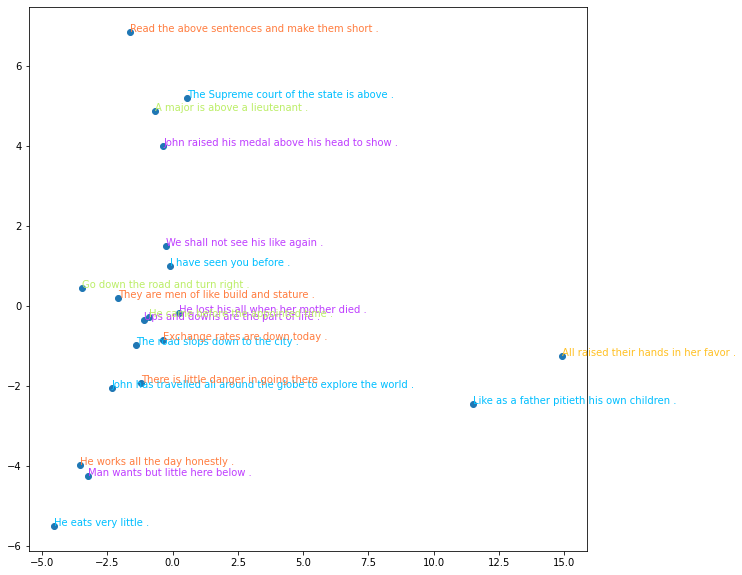

In [36]:
dump_on_surface(word_embeddings,
                sample_str,
                dump_3d=False,
                fitting="tsne",
                color_by="object",
                word_pos=word_pos)

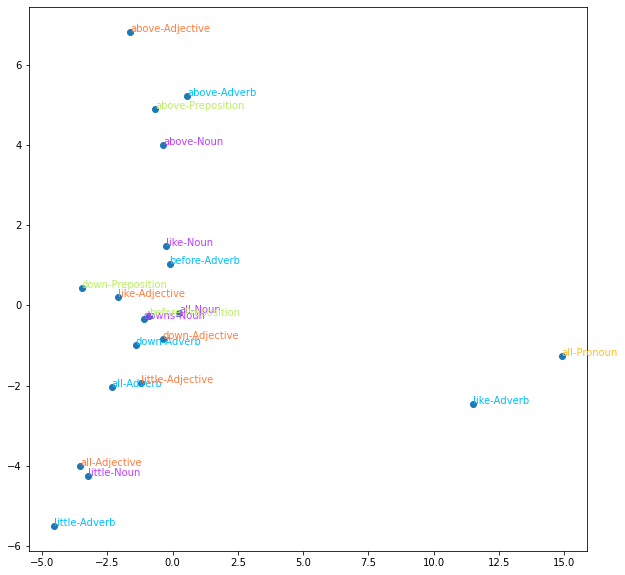

In [37]:
dump_on_surface(word_embeddings,
                word_with_pos,
                dump_3d=False,
                fitting="tsne",
                color_by="object",
                word_pos=word_pos)

In [ ]:
train(model, train_iter, optimizer, criterion)

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
torch.save(model, '/content/drive/MyDrive/CS 546 Final Project /BERTPOS/model.pt')

In [ ]:
fine_tuned_model = torch.load('/content/drive/MyDrive/CS 546 Final Project /BERTPOS/model.pt')

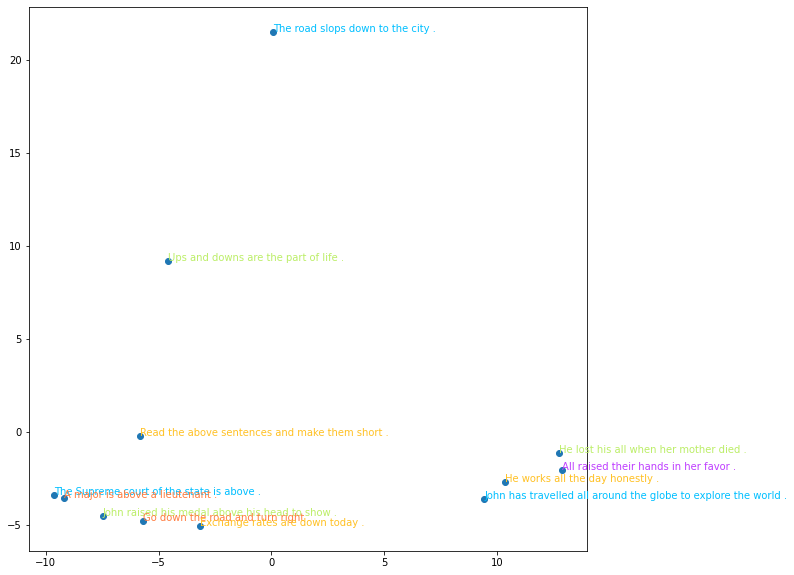

In [56]:
# fine-tuned

k1 = np.array(bertposembedding(fine_tuned_model, sample_str[0]).cpu())
k2 = np.array(bertposembedding(fine_tuned_model, sample_str[1]).cpu())
k3 = np.array(bertposembedding(fine_tuned_model, sample_str[2]).cpu())
k4 = np.array(bertposembedding(fine_tuned_model, sample_str[3]).cpu())
k5 = np.array(bertposembedding(fine_tuned_model, sample_str[4]).cpu())
k6 = np.array(bertposembedding(fine_tuned_model, sample_str[5]).cpu())
k7 = np.array(bertposembedding(fine_tuned_model, sample_str[6]).cpu())
k8 = np.array(bertposembedding(fine_tuned_model, sample_str[7]).cpu())
k9 = np.array(bertposembedding(fine_tuned_model, sample_str[8]).cpu())
k10 = np.array(bertposembedding(fine_tuned_model, sample_str[9]).cpu())
k11 = np.array(bertposembedding(fine_tuned_model, sample_str[10]).cpu())
k12 = np.array(bertposembedding(fine_tuned_model, sample_str[11]).cpu())
k13 = np.array(bertposembedding(fine_tuned_model, sample_str[12]).cpu())
k14 = np.array(bertposembedding(fine_tuned_model, sample_str[13]).cpu())
k15 = np.array(bertposembedding(fine_tuned_model, sample_str[14]).cpu())
k16 = np.array(bertposembedding(fine_tuned_model, sample_str[15]).cpu())
k17 = np.array(bertposembedding(fine_tuned_model, sample_str[16]).cpu())
k18 = np.array(bertposembedding(fine_tuned_model, sample_str[17]).cpu())
k19 = np.array(bertposembedding(fine_tuned_model, sample_str[18]).cpu())
k20 = np.array(bertposembedding(fine_tuned_model, sample_str[19]).cpu())


word_embeddings_ft = [k1[8], k2[4], k3[3], k4[5], k5[4], k6[2], k7[4], k8[3], k9[3], k10[4], k11[1], k12[4],
                   k13[5],k14[3],k15[5],k16[6],k17[1],k18[3],k19[4],k20[4]]

dump_on_surface(word_embeddings_ft,
                sample_str,
                dump_3d=False,
                fitting="tsne",
                color_by="object",
                word_pos=word_pos)

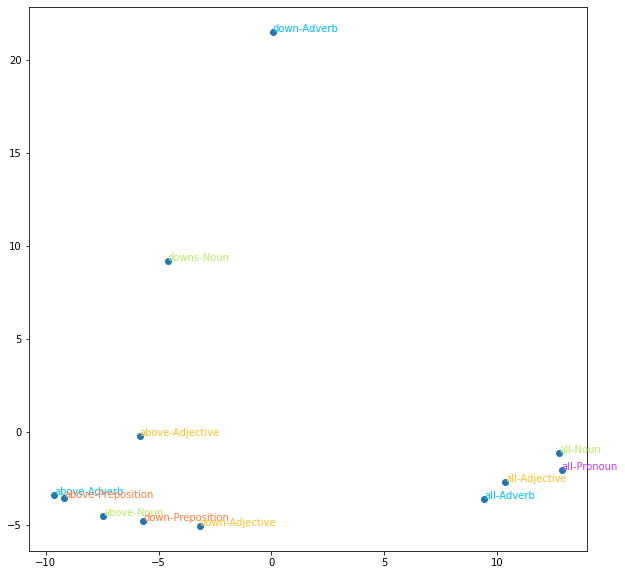

In [57]:
dump_on_surface(word_embeddings_ft,
                word_with_pos,
                dump_3d=False,
                fitting="tsne",
                color_by="object",
                word_pos=word_pos)

## Experiment

In [ ]:
sentences = ['i want to eat bread',
 'i want to eat apple',
 'i want to drink water',
 'i want to drink beer', 
 'i want to read book', 
 'i want to read newspaper',
 'i can eat bread', 
 'i can eat apple', 
 'i can drink water',
 'i can drink beer', 
 'i can read book', 
 'i can read newspaper',
 'we want to eat bread',
 'we want to eat apple',
 'we want to drink water',
 'we want to drink beer',
 'we want to read book', 
 'we want to read newspaper',
 'we can eat bread', 
 'we can eat apple', 
 'we can drink water',
 'we can drink beer', 
 'we can read book', 
 'we can read newspaper',
 'i eat bread', 
 'i eat apple', 
 'i drink water', 
 'i drink beer', 
 'i read book', 
 'i read newspaper',
 'we eat bread', 
 'we eat apple', 
 'we drink water',
 'we drink beer',
 'we read book', 
 'we read newspaper',
 ]
sentences[0]

'i want to eat bread'

In [ ]:
MAX_LEN = 8

In [ ]:
bert_model_nottrained = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
bert_model_nottrained.eval()
tokenizer_nottrained = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
#Lets try to do 1 cycle of Bert encoding
sentence = "i eat apple"
#1) append [CLS] and [SEP]
bert_text = "[CLS] " + sentence + " [SEP]"

#2)Tokenize text
tokenized_text = tokenizer_nottrained.tokenize(bert_text)
print("tokenized_text :",tokenized_text)

#3)Convert tokens to ids in Bert vocublary
indexed_tokens = tokenizer_nottrained.convert_tokens_to_ids(tokenized_text)
print("indexed_tokens :",indexed_tokens)

#4)Prepare segment ids(since we have single sentence all 1)
segments_ids = [1] * len(tokenized_text)
print("segments_ids :",segments_ids)
#5)Convert to tensor and call model
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])  
outputs = bert_model_nottrained(tokens_tensor, segments_tensors)
print("items returned by Bert model : ",outputs.keys())

print("last_hidden_state",list(outputs["last_hidden_state"].shape) )

print("pooler_output",list(outputs["pooler_output"].shape ) )


print("hidden_states len : ", len(outputs["hidden_states"]) )
for i in range(len(outputs["hidden_states"])):
    if i == 0:
        print("BertEmbeddings : ",list( outputs["hidden_states"][i].shape ))
    else:    
        print("Transformer "+str(i)+" : ",list( outputs["hidden_states"][i].shape ))

tokenized_text : ['[CLS]', 'i', 'eat', 'apple', '[SEP]']
indexed_tokens : [101, 1045, 4521, 6207, 102]
segments_ids : [1, 1, 1, 1, 1]
items returned by Bert model :  odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
last_hidden_state [1, 5, 768]
pooler_output [1, 768]
hidden_states len :  13
BertEmbeddings :  [1, 5, 768]
Transformer 1 :  [1, 5, 768]
Transformer 2 :  [1, 5, 768]
Transformer 3 :  [1, 5, 768]
Transformer 4 :  [1, 5, 768]
Transformer 5 :  [1, 5, 768]
Transformer 6 :  [1, 5, 768]
Transformer 7 :  [1, 5, 768]
Transformer 8 :  [1, 5, 768]
Transformer 9 :  [1, 5, 768]
Transformer 10 :  [1, 5, 768]
Transformer 11 :  [1, 5, 768]
Transformer 12 :  [1, 5, 768]


In [ ]:
# NOT ORIGINAL
# def get_word_embeddings(tokenizer_,model_,sentence,word):
#   embeddings = get_word_embeddings_sum(tokenizer_,model_, sentence )
#   embeddings_as_pairs = get_embeddings_as_pair(tokenizer_,model_,sentence,embeddings)
#   word_embeddings = []
#   for pair in embeddings_as_pairs:
#     if pair.word == word:
#       return pair.vector
      

In [ ]:
word_embeddings = get_word_embeddings(tokenizer_nottrained,bert_model_nottrained,sentences[0],"eat")

In [ ]:
# Contextual embedding without fine-tuning for the word 'eat' in sentence 'i want to eat bread'
#print(word_embeddings.word, len(word_embeddings.vector))
len(word_embeddings)

1

In [ ]:
# def get_word_embeddings(tokenizer_,model_,sentence,word):
#   embeddings = get_word_embeddings_sum(tokenizer_,model_, sentence )
#   embeddings_as_pairs = get_embeddings_as_pair(tokenizer_,model_,sentence,embeddings)
#   word_embeddings = []
#   for pair in embeddings_as_pairs:
#     if pair.word == word:
#       word_embeddings.append( pair )
#   return word_embeddings  

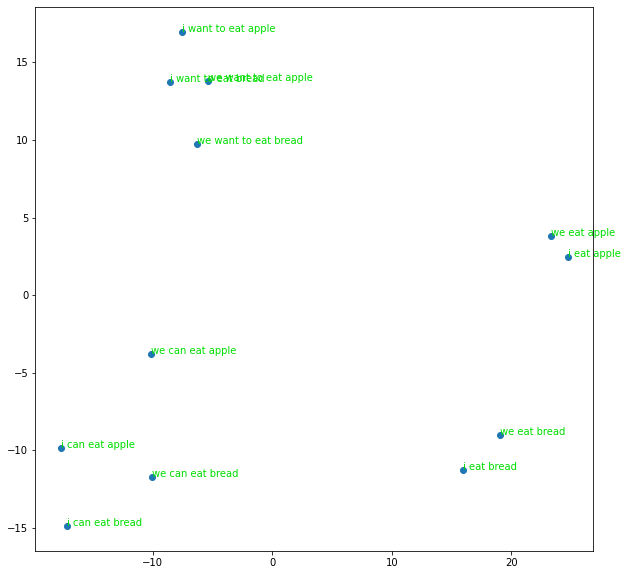

In [ ]:
eat_sentences = [ s for s in sentences if s.find("eat") > 0 ]
word_embeddings = [ get_word_embeddings(tokenizer_nottrained,bert_model_nottrained,s,"eat")[0].vector.numpy() for s in eat_sentences ]

dump_on_surface(word_embeddings, eat_sentences, dump_3d=False,fitting="tsne",color_by="verb")

In [ ]:
#len(word_embeddings)
w1 = word_embeddings[0]
w2 = word_embeddings[1]
w_total = [w1, w2]
eat_total = [eat_sentences[0], eat_sentences[1]]
dump_on_surface(w_total,eat_total,dump_3d=False,fitting="tsne",color_by="object")

In [ ]:
# Lets take sentences with verb eat and ONLY get embedding of verb EAT
# Below are embedding of single verb eat with their sentence
# see how embeddings for them are generated
# results seems nice, we have 3 patterns can,want,verb and seems they are scattered over space

#eat_sentences = [ s for s in sentences if s.find("eat") > 0 ]
#word_embeddings = [ get_word_embeddings(tokenizer_nottrained,bert_model_nottrained,s,"eat")[0].vector.numpy() for s in eat_sentences ]

#eat_sentences = sentences[0]
dump_on_surface(word_embeddings,eat_sentences,dump_3d=False,fitting="tsne",color_by="object")

## Extra type

In [ ]:
#For sentence embedding we can try 3 approaches
#According to your problem best approach can change.
#At internet I read CLS is not a good solution if u dont train CLS for your task.

#1)Get CLS as sentence embedding
outputs = [ get_bert_output_cls(tokenizer_nottrained,bert_model_nottrained,s).detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by CLS")

#2)Get Pooler layer output
outputs = [ get_bert_output_pooled(tokenizer_nottrained,bert_model_nottrained,s).detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by Pooler")

#3)Get a combination of hidden layers
outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,type="meansum").detach().numpy() for s in sentences]
dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title="Sentence by Hidden Layers")

#I think 3rd method , Hidden Layers seems best, because eat and drink are more near
#it makes sense when they are near

In [ ]:
#Now I want to see what all hidden layers are generating
#Infact at first layers , groups are more clear,
#But at the end everything gets more closer.
for i in range(13):
    title = "Tranformer"+str(i) if i > 0 else "Embedding"
    pooler_outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,layer_start=i,layer_end=i+1,type="meanmean").detach().numpy() for s in sentences]
    #pooler_outputs = [ get_sentence_embedding(tokenizer_nottrained,bert_model_nottrained,s,layer_start=i,layer_end=i+1,type="meansum").detach().numpy() for s in sentences]
    #show_embeddings([],[],pooler_outputs,sentences,fitting="pca")
    dump_on_surface(pooler_outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="object",title=title)